In [71]:
from lda import *
from grid_search_lda import *
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score
import matplotlib
import matplotlib.pyplot as plt
# use default matplotlib backend
matplotlib.style.use('default')

# LDA Model Analysis

In [6]:
LOAD_SAVED = False
PRINT_COHERENCE = True

In [7]:
# k_implicit, k_covid, k_offenseval = gridsearch_lda()
k_implicit, k_covid, k_offenseval = 13, 13, 13

## Training LDA Models
We will create bigrams and train LDA models for each of the three datasets we have. We will use the validation dataset to test the impact of using LDA output as features for the model and the test dataset to evaluate cross-domain generalization.

### Implicit Hate

In [8]:
implicit_df_train = pd.read_csv("./../../data/implicithate_train.csv")
lda_implicit, vectors_implicit_train, coherence_implicit = lda(implicit_df_train, load_from="../../data/lda_implicit.model") if LOAD_SAVED else lda(implicit_df_train, k=k_implicit)

In [9]:
if PRINT_COHERENCE:
    print('Coherence Score:', coherence_implicit)

Coherence Score: 0.4223278167498282


In [10]:
if not LOAD_SAVED:
    lda_implicit.save('../../saved-models/lda_implicit.model')

### COVID Hate

In [11]:
covid_df_train = pd.read_csv("./../../data/covidhate_train.csv")
lda_covid, vectors_covid_train, coherence_covid = lda(covid_df_train, load_from="../../saved-models/lda_covid.model") if LOAD_SAVED else lda(covid_df_train, k=k_covid)

In [12]:
if PRINT_COHERENCE:
    print('Coherence Score:', coherence_covid)

Coherence Score: 0.5020425509510187


In [13]:
if not LOAD_SAVED:
    lda_covid.save('../../saved-models/lda_covid.model')

### Offensval

In [14]:
offenseval_df_train = pd.read_csv("./../../data/offenseval_train.csv")
lda_offenseval, vectors_offenseval_train, coherence_offenseval = lda(offenseval_df_train, load_from="../../saved-models/lda_offenseval.model") if LOAD_SAVED else lda(offenseval_df_train, k=k_offenseval)

In [15]:
if PRINT_COHERENCE:
    print('Coherence Score:', coherence_offenseval)

Coherence Score: 0.3811385300677117


In [16]:
if not LOAD_SAVED:
    lda_offenseval.save('../../saved-models/lda_offenseval.model')

## Comparing SVM Models (LDA vs. TF-IDF as input features)

### Create the SVMs using LDA features

#### Implicit Hate

In [17]:
X = np.array(vectors_implicit_train)
y = np.array(implicit_df_train['label'])
svm_implicit_lda = LinearSVC(tol=1e-3, class_weight="balanced").fit(X, y)

In [18]:
implicit_df_val = pd.read_csv("./../../data/implicithate_val.csv")
implicit_df_val = create_tokenized_column(implicit_df_val)
implicit_bigrams_val = create_bigrams(implicit_df_val["tokenized"])
implicit_dict_val, implicit_corpus_val = get_dict_and_corpus(implicit_bigrams_val)
implicit_val_vectors = get_vectors(lda_implicit, implicit_corpus_val, k=13)

In [19]:
implicit_preds_lda = svm_implicit_lda.predict(implicit_val_vectors)
print(classification_report(implicit_df_val['label'], implicit_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.63      0.58      0.60      2150
        hate       0.38      0.43      0.40      1284

    accuracy                           0.52      3434
   macro avg       0.50      0.50      0.50      3434
weighted avg       0.53      0.52      0.53      3434



#### COVID Hate

In [20]:
X = np.array(vectors_covid_train)
y = np.array(covid_df_train['label'])
svm_covid_lda = LinearSVC(tol=1e-3, class_weight="balanced").fit(X, y)

In [21]:
covid_df_val = pd.read_csv("./../../data/covidhate_val.csv")
covid_df_val = create_tokenized_column(covid_df_val)
covid_bigrams_val = create_bigrams(covid_df_val["tokenized"])
covid_dict_val, covid_corpus_val = get_dict_and_corpus(covid_bigrams_val)
covid_val_vectors = get_vectors(lda_covid, covid_corpus_val, k=13)

In [22]:
covid_preds_lda = svm_covid_lda.predict(covid_val_vectors)
print(classification_report(covid_df_val['label'], covid_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.85      0.82      0.84       312
        hate       0.15      0.18      0.17        55

    accuracy                           0.72       367
   macro avg       0.50      0.50      0.50       367
weighted avg       0.75      0.72      0.73       367



#### Offenseval

In [23]:
X = np.array(vectors_offenseval_train)
y = np.array(offenseval_df_train['label'])
svm_offenseval_lda = LinearSVC(tol=1e-3, class_weight="balanced").fit(X, y)

In [24]:
offenseval_df_val = pd.read_csv("./../../data/offenseval_val.csv")
offenseval_df_val = create_tokenized_column(offenseval_df_val)
offenseval_bigrams_val = create_bigrams(offenseval_df_val["tokenized"])
offenseval_dict_val, offenseval_corpus_val = get_dict_and_corpus(offenseval_bigrams_val)
offenseval_val_vectors = get_vectors(lda_offenseval, offenseval_corpus_val, k=13)

In [25]:
offenseval_preds_lda = svm_offenseval_lda.predict(offenseval_val_vectors)
print(classification_report(offenseval_df_val['label'], offenseval_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.66      0.56      0.61      1733
        hate       0.35      0.45      0.40       915

    accuracy                           0.52      2648
   macro avg       0.51      0.51      0.50      2648
weighted avg       0.55      0.52      0.53      2648



### Create the SVMs using TF-IDF features

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["from", "subject", "re", "edu", "use"])

#### Implicit Hate

In [27]:
implicit_tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000)
implicit_tfidf.fit(implicit_df_train['text'])
implicit_tfidf_train = implicit_tfidf.transform(implicit_df_train['text'])
implicit_tfidf_val = implicit_tfidf.transform(implicit_df_val['text'])
svm_implicit_tfidf = LinearSVC(tol=1e-3, class_weight="balanced").fit(implicit_tfidf_train, implicit_df_train['label'])

In [28]:
implicit_preds_tfidf = svm_implicit_tfidf.predict(implicit_tfidf_val)
print(classification_report(implicit_df_val['label'], implicit_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.77      0.73      0.75      2150
        hate       0.58      0.64      0.61      1284

    accuracy                           0.70      3434
   macro avg       0.68      0.68      0.68      3434
weighted avg       0.70      0.70      0.70      3434



#### COVID Hate

In [29]:
covid_tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000)
covid_tfidf.fit(covid_df_train['text'])
covid_tfidf_train = covid_tfidf.transform(covid_df_train['text'])
covid_tfidf_val = covid_tfidf.transform(covid_df_val['text'])
svm_covid_tfidf = LinearSVC(tol=1e-3, class_weight="balanced").fit(covid_tfidf_train, covid_df_train['label'])

In [30]:
covid_preds_tfidf = svm_covid_tfidf.predict(covid_tfidf_val)
print(classification_report(covid_df_val['label'], covid_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.93      0.93      0.93       312
        hate       0.60      0.62      0.61        55

    accuracy                           0.88       367
   macro avg       0.76      0.77      0.77       367
weighted avg       0.88      0.88      0.88       367



#### Offenseval

In [31]:
offenseval_tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000)
offenseval_tfidf.fit(offenseval_df_train['text'])
offenseval_tfidf_train = offenseval_tfidf.transform(offenseval_df_train['text'])
offenseval_tfidf_val = offenseval_tfidf.transform(offenseval_df_val['text'])
svm_offenseval_tfidf = LinearSVC(tol=1e-3, class_weight="balanced").fit(offenseval_tfidf_train, offenseval_df_train['label'])

In [32]:
offenseval_preds_tfidf = svm_offenseval_tfidf.predict(offenseval_tfidf_val)
print(classification_report(offenseval_df_val['label'], offenseval_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.79      0.77      0.78      1733
        hate       0.59      0.62      0.61       915

    accuracy                           0.72      2648
   macro avg       0.69      0.70      0.69      2648
weighted avg       0.72      0.72      0.72      2648



### Evaluate the performance of the SVMs

C:\Users\Kai\AppData\Local\Temp\ipykernel_18720\673200413.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


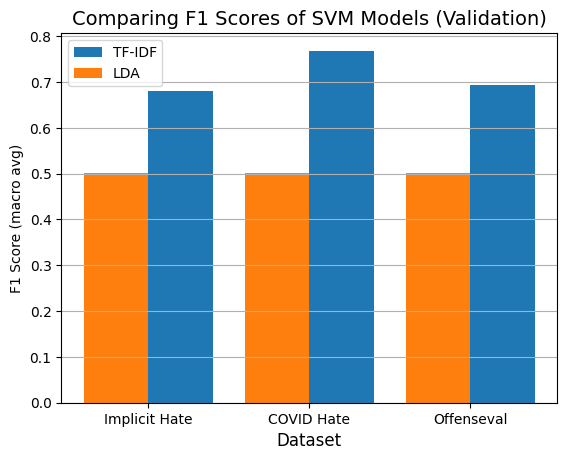

In [72]:
# compare the macro avg f1 score of the three models between the tfidf and lda versions of SVMs
f1_scores_tfidf = [f1_score(implicit_df_val['label'], implicit_preds_tfidf, average='macro'), f1_score(covid_df_val['label'], covid_preds_tfidf, average='macro'), f1_score(offenseval_df_val['label'], offenseval_preds_tfidf, average='macro')]
plt.bar(np.arange(3)+0.2, f1_scores_tfidf, 0.4, label = "TF-IDF")
f1_scores_lda = [f1_score(implicit_df_val['label'], implicit_preds_lda, average='macro'), f1_score(covid_df_val['label'], covid_preds_lda, average='macro'), f1_score(offenseval_df_val['label'], offenseval_preds_lda, average='macro')]
plt.bar(np.arange(3)-0.2, f1_scores_lda, 0.4, label = "LDA")
plt.xticks(np.arange(3), ['Implicit Hate', 'COVID Hate', 'Offenseval'])
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("F1 Score (macro avg)")
plt.title("Comparing F1 Scores of SVM Models (Validation)", fontsize=14)
plt.legend()
plt.grid(True, axis='y')
plt.show()

## Cross-Domain Analysis

### Preprocessing

In [34]:
implicit_df_test = pd.read_csv("./../../data/implicithate_test.csv")
implicit_df_test = create_tokenized_column(implicit_df_test)
implicit_bigrams_test = create_bigrams(implicit_df_test["tokenized"])
implicit_dict_test, implicit_corpus_test = get_dict_and_corpus(implicit_bigrams_test)
implicit_test_vectors = get_vectors(lda_implicit, implicit_corpus_test, k=13)
implicit_tfidf_test = implicit_tfidf.transform(implicit_df_test['text'])

In [35]:
covid_df_test = pd.read_csv("./../../data/covidhate_test.csv")
covid_df_test = create_tokenized_column(covid_df_test)
covid_bigrams_test = create_bigrams(covid_df_test["tokenized"])
covid_dict_test, covid_corpus_test = get_dict_and_corpus(covid_bigrams_test)
covid_test_vectors = get_vectors(lda_covid, covid_corpus_test, k=13)
covid_tfidf_test = covid_tfidf.transform(covid_df_test['text'])

In [36]:
offenseval_df_test = pd.read_csv("./../../data/offenseval_test.csv")
offenseval_df_test = create_tokenized_column(offenseval_df_test)
offenseval_bigrams_test = create_bigrams(offenseval_df_test["tokenized"])
offenseval_dict_test, offenseval_corpus_test = get_dict_and_corpus(offenseval_bigrams_test)
offenseval_test_vectors = get_vectors(lda_offenseval, offenseval_corpus_test, k=13)
offenseval_tfidf_test = offenseval_tfidf.transform(offenseval_df_test['text'])

### Implicit Hate model on COVID Hate dataset

In [37]:
f1_scores_crossdomain = {}

In [38]:
implicit_covid_preds_lda = svm_implicit_lda.predict(covid_test_vectors)
print(classification_report(covid_df_test['label'], implicit_covid_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.83      0.32      0.46       370
        hate       0.20      0.72      0.31        88

    accuracy                           0.40       458
   macro avg       0.51      0.52      0.39       458
weighted avg       0.71      0.40      0.43       458



In [39]:
implicit_covid_preds_tfidf = svm_implicit_tfidf.predict(covid_tfidf_test)
print(classification_report(covid_df_test['label'], implicit_covid_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.79      0.66      0.72       370
        hate       0.17      0.28      0.21        88

    accuracy                           0.59       458
   macro avg       0.48      0.47      0.47       458
weighted avg       0.67      0.59      0.62       458



In [40]:
f1_scores_crossdomain["implicit_covid"] = [f1_score(covid_df_test['label'], implicit_covid_preds_lda, average='macro'), f1_score(covid_df_test['label'], implicit_covid_preds_tfidf, average='macro')]

### COVID Hate model on Implicit Hate dataset

In [41]:
covid_implicit_preds_lda = svm_covid_lda.predict(implicit_test_vectors)
print(classification_report(implicit_df_test['label'], covid_implicit_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.58      0.10      0.17      2674
        hate       0.37      0.88      0.52      1617

    accuracy                           0.40      4291
   macro avg       0.48      0.49      0.35      4291
weighted avg       0.50      0.40      0.31      4291



In [42]:
coivd_implicit_preds_tfidf = svm_covid_tfidf.predict(implicit_tfidf_test)
print(classification_report(implicit_df_test['label'], coivd_implicit_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.62      0.97      0.76      2674
        hate       0.39      0.03      0.05      1617

    accuracy                           0.62      4291
   macro avg       0.51      0.50      0.41      4291
weighted avg       0.54      0.62      0.49      4291



In [43]:
f1_scores_crossdomain["covid_implicit"] = [f1_score(implicit_df_test['label'], covid_implicit_preds_lda, average='macro'), f1_score(implicit_df_test['label'], coivd_implicit_preds_tfidf, average='macro')]

### Implicit Hate model on Offenseval dataset

In [44]:
implicit_offenseval_preds_lda = svm_implicit_lda.predict(offenseval_test_vectors)
print(classification_report(offenseval_df_test['label'], implicit_offenseval_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       1.00      0.00      0.00       620
        hate       0.28      1.00      0.44       240

    accuracy                           0.28       860
   macro avg       0.64      0.50      0.22       860
weighted avg       0.80      0.28      0.12       860



In [45]:
implicit_offenseval_preds_tfidf = svm_implicit_tfidf.predict(offenseval_tfidf_test)
print(classification_report(offenseval_df_test['label'], implicit_offenseval_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.75      0.54      0.63       620
        hate       0.31      0.52      0.39       240

    accuracy                           0.54       860
   macro avg       0.53      0.53      0.51       860
weighted avg       0.62      0.54      0.56       860



In [46]:
f1_scores_crossdomain["implicit_offenseval"] = [f1_score(offenseval_df_test['label'], implicit_offenseval_preds_lda, average='macro'), f1_score(offenseval_df_test['label'], implicit_offenseval_preds_tfidf, average='macro')]

### Offensval model on Implicit Hate dataset

In [47]:
offenseval_implicit_preds_lda = svm_offenseval_lda.predict(implicit_test_vectors)
print(classification_report(implicit_df_test['label'], offenseval_implicit_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.75      0.00      0.00      2674
        hate       0.38      1.00      0.55      1617

    accuracy                           0.38      4291
   macro avg       0.56      0.50      0.27      4291
weighted avg       0.61      0.38      0.21      4291



In [48]:
offenseval_implicit_preds_tfidf = svm_offenseval_tfidf.predict(implicit_tfidf_test)
print(classification_report(implicit_df_test['label'], offenseval_implicit_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.64      0.72      0.68      2674
        hate       0.41      0.32      0.36      1617

    accuracy                           0.57      4291
   macro avg       0.52      0.52      0.52      4291
weighted avg       0.55      0.57      0.56      4291



In [49]:
f1_scores_crossdomain["offenseval_implicit"] = [f1_score(implicit_df_test['label'], offenseval_implicit_preds_lda, average='macro'), f1_score(implicit_df_test['label'], offenseval_implicit_preds_tfidf, average='macro')]

### COVID Hate model on Offenseval dataset

In [50]:
covid_offenseval_preds_lda = svm_covid_lda.predict(offenseval_test_vectors)
print(classification_report(offenseval_df_test['label'], covid_offenseval_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.89      0.05      0.10       620
        hate       0.29      0.98      0.44       240

    accuracy                           0.31       860
   macro avg       0.59      0.52      0.27       860
weighted avg       0.72      0.31      0.20       860



In [51]:
covid_offenseval_preds_tfidf = svm_covid_tfidf.predict(offenseval_tfidf_test)
print(classification_report(offenseval_df_test['label'], covid_offenseval_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.71      0.95      0.81       620
        hate       0.03      0.00      0.01       240

    accuracy                           0.68       860
   macro avg       0.37      0.48      0.41       860
weighted avg       0.52      0.68      0.59       860



In [52]:
f1_scores_crossdomain["covid_offenseval"] = [f1_score(offenseval_df_test['label'], covid_offenseval_preds_lda, average='macro'), f1_score(offenseval_df_test['label'], covid_offenseval_preds_tfidf, average='macro')]

### Offenseval model on COVID Hate dataset

In [53]:
offenseval_covid_preds_lda = svm_offenseval_lda.predict(covid_test_vectors)
print(classification_report(covid_df_test['label'], offenseval_covid_preds_lda, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.94      0.08      0.14       370
        hate       0.20      0.98      0.33        88

    accuracy                           0.25       458
   macro avg       0.57      0.53      0.24       458
weighted avg       0.79      0.25      0.18       458



In [54]:
offenseval_covid_preds_tfidf = svm_offenseval_tfidf.predict(covid_tfidf_test)
print(classification_report(covid_df_test['label'], offenseval_covid_preds_tfidf, labels=[0, 1], target_names=['non-hate', 'hate']))

              precision    recall  f1-score   support

    non-hate       0.78      0.59      0.67       370
        hate       0.16      0.32      0.21        88

    accuracy                           0.54       458
   macro avg       0.47      0.46      0.44       458
weighted avg       0.66      0.54      0.59       458



In [55]:
f1_scores_crossdomain["offenseval_covid"] = [f1_score(covid_df_test['label'], offenseval_covid_preds_lda, average='macro'), f1_score(covid_df_test['label'], offenseval_covid_preds_tfidf, average='macro')]

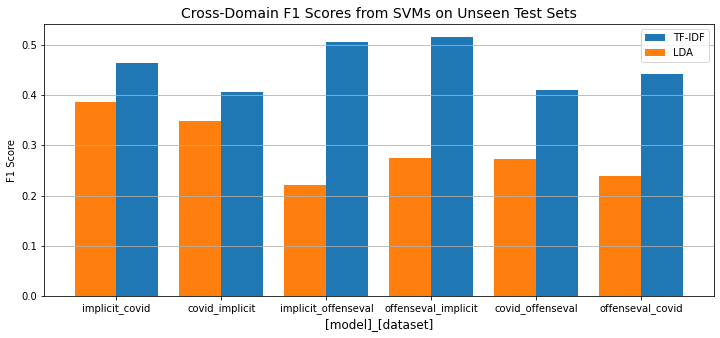

In [58]:
# make a wide figure
fig, ax = plt.subplots(figsize=(12, 5))
x_axis = np.arange(len(f1_scores_crossdomain.keys()))
plt.bar(x_axis + 0.2, [y[1] for y in list(f1_scores_crossdomain.values())], align='center', width=0.4, label='TF-IDF')
plt.bar(x_axis - 0.2, [y[0] for y in list(f1_scores_crossdomain.values())], align='center', width=0.4, label='LDA')
plt.xticks(x_axis, list(f1_scores_crossdomain.keys()))
plt.xlabel('[model]_[dataset]', fontsize=12)
plt.ylabel('F1 Score')
plt.title('Cross-Domain F1 Scores from SVMs on Unseen Test Sets', fontsize=14)
plt.grid(True, axis='y')
plt.legend()
plt.show()